# Anomaly Detection For Timeseries of Networks

There is a particular type of sea slug who have gills on the outside of their body. When you squirt water at these gills, they withdraw into the slug. The interesting thing about this type of slug is that the brain network involved in this gill withdrawal reflex is entirely mapped out, from the neurons which detect and transmit information about the water into the slug's brain, to the neurons that leave the brain and fire at its muscles. (For the interested, this is a real thing - look up Eric Kandel's research on Aplysia!)

Say you're a researcher studying these sea slugs, and you have a bunch of brain networks of the same slug. Each node is a single neuron, and edges denote connections between neurons. Each of the brain networks that you have were taken at different time points: some before water started getting squirted at the slug's gills, and some as the water was getting squirted. Your goal is to reconstruct when water started to get squirted, using only the networks themselves. You hypothesize that there should be some signal change in your networks which can tell you the particular time at which water started getting squirted. Given the network data you have, how do you figure out which timepoints these are?

The broader class of problems this question addresses is called *anomaly detection*. The idea in general is that you have a bunch of snapshots of the same network over time. Although the nodes are the same, the edges are changing at each time point. Your goal is to figure out which time points correspond to the most change, either in the entire network or in particular groups of nodes. You can think of a network as "anomalous" with respect to time if some potentially small group of nodes within the network concurrently changes behavior at some point in time compared to the recent past, while the remaining nodes continue with whatever noisy, normal behavior they had.

In particular, what we would really like to do is separate the signal from the noise. All of the nodes in the network are likely changing a bit over time, since there is some variability intrinsic in the system. Random noise might just dictate that some edges get randomly deleted and some get randomly created, but we want to figure out when neurons are changing as the result of the squirting in particular.

Let's simulate some network timeseries data so that we can explore anomaly detection more thoroughly.

## Simulating Network Timeseries Data

For this data generation, we're going to assemble a set of 12 time-points for a network directly from its latent positions (we'll assume that each time-point for the network is drawn from an RDPG). Ten of these time points will just have natural variability, and two will have a subset of nodes whose latent positions were perturbed a bit. These two will be the anomalies.

We'll say that the latent positions for the network are one-dimensional, and that it has 100 nodes. There will be the same number of adjacency matrices as there are time points, since our network will be changing over time.

For each of the ten normal time points, we'll:
1. Generate 100 random latent positions. Each latent position will be a (uniformly) random number between .2 and .8.
2. Use graspologic's rdpg function to sample an adjacency matrix using these latent positions.

And for each of the two perturbed time points, we'll:
1. Generate 100 random latent positions, in the same way as above.
2. Add a small amount of noise to 20 of these latent positions.
3. Generate an adjacency matrix as above

Once we have this simulated data, we'll move into some discussion about how we'll approach detecting the anomalous time points.

Below is code for generating the data. We define a function to generate a particular time-point, with an argument which toggles whether we'll perturb latent positions in the time point. Then, we just loop through our time-points and generate a new adjacency matrix for each one.

The latent positions are just single numbers, distributed uniformly between 0.2 and 0.8. To make the perturbed time-points, we just add a bit of noise to the first twenty rows of the latent position matrix.

1.3740819548444545


/Users/alex/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/alex/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

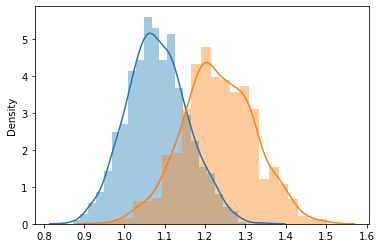

In [146]:
### its broken weeeeeeeeee
### test code block

from graspologic.simulations import rdpg
X = np.random.uniform(.2, .8, size=(100, 1))
A = rdpg(X)
B = rdpg(X)

def get_statistic(adjacencies, return_latents=False):
    """
    Get the operator norm of the difference of two matrices.
    """
    omni = OMNI(n_components=2)
    latents_est = omni.fit_transform(adjacencies)
    X, Y = latents_est[0], latents_est[1]
    y = np.linalg.norm(X - Y, ord=2)
    if return_latents:
        return y, X
    else:
        return y

latents = omni.fit_transform([A, B])

ys_same = []
for i in range(1000):
    A_, B_ = rdpg(latents[0]), rdpg(latents[0])
    y_ = get_statistic([A_, B_])
    ys_same.append(y_)
    
ys_diff = []
for i in range(1000):
    A_, B_ = rdpg(latents[0]), rdpg(latents[1])
    y_ = get_statistic([A_, B_])
    ys_diff.append(y_)

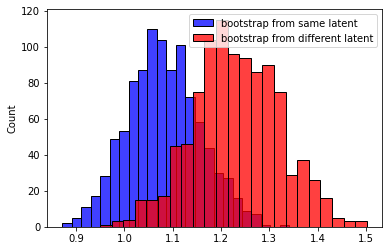

In [155]:
sns.histplot(ys_same, label="bootstrap from same latent", color="blue")
sns.histplot(ys_diff, label="bootstrap from different latent", color="red")

plt.gca().legend()

In [31]:
import numpy as np
from graspologic.simulations import rdpg


def gen_timepoint(X, perturbed=False, n_perturbed=20, perturbation=.1):
    if perturbed:
        X = np.squeeze(X)
        baseline = np.array([1, -1, 0])
        delta = np.repeat(baseline, (n_perturbed//2, 
                                     n_perturbed//2, 
                                     nodes-n_perturbed))
        X += (delta * perturbation)
    if X.ndim == 1:
        X = X[:, np.newaxis]
    A = rdpg(X)
    return A
    

time_points = 12
nodes = 100
X = np.random.uniform(.2, .8, size=nodes)
networks = []

for time in range(time_points-2):
    A = gen_timepoint(X)
    networks.append(A)

for perturbed_time in range(5, 7):
    A = gen_timepoint(X, perturbed=True)
    networks.insert(perturbed_time, A)
    
networks = np.array(networks)

You can see the adjacency matrices we generated below. Note that you can't really distinguish a difference between the ten normal time points and the two perturbed time points with the naked eye, even though the difference is there, so it would be pretty difficult to manually mark the time points - and if you have many time points, rather than just a few, you'd want to be able to automate the process.

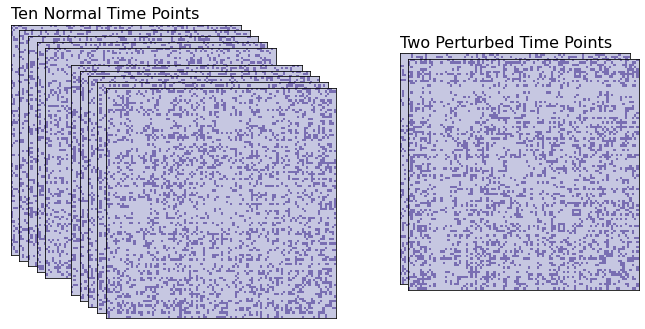

In [32]:
import matplotlib.pyplot as plt
from graphbook_code import heatmap
import seaborn as sns

def rm_ticks(ax, x=False, y=False, **kwargs):
    if x is not None:
        ax.axes.xaxis.set_visible(x)
    if y is not None:
        ax.axes.yaxis.set_visible(y)
    sns.despine(ax=ax, **kwargs)

fig = plt.figure();

perturbed_points = {5, 6}
for i in range(time_points):
    if i not in perturbed_points:
        ax = fig.add_axes([.02*i, -.02*i, .8, .8])
    else:
        ax = fig.add_axes([.02*i+.8, -.02*i, .8, .8])
    ax = heatmap(networks[i], ax=ax, cbar=False)
    if i == 0:
        ax.set_title("Ten Normal Time Points", loc="left", fontsize=16)
    if i == 5:
        ax.set_title("Two Perturbed Time Points", loc="left", fontsize=16)
    rm_ticks(ax, top=False, right=False)

## How Do We Figure Out Which Time Points Are Anomalies?

It's time to start thinking about how we'd approach figuring out which of the time points are anomalies. 

One of the simplest approaches to this problem might just be to figure out which node has the highest count of edge changes across your timeseries. For each node across the timeseries, you'd count the number of new edges that appeared (compared to the previous point in time), and the number of existing edges that were deleted. Whichever count is highest could be your anomalous node.

This might give you a rough estimate -- and you could even potentially find perturbed time points with this approach -- but it's not necessarily the best solution. Counting edges doesn't account for other important pieces of information: for instance, you might be interested in which other nodes new edges were formed with. It seems like deleting or creating edges with more important nodes, for instance, should be weighted higher than deleting or creating edges with unimportant nodes.

So let's try another method. You might actually be able to guess it! The idea will be to simply estimate each network's latent positions, followed by a hypothesis testing approach. Here's the idea.

Let's call the latent positions for our network $X^{(t)}$ for the snapshot of the network at time $t$. You're trying to find specific time points -- $X^{(i)}$ -- which are different from their previous time point $X^{(i-1)}$ by a large margin. You can define "different" as "difference in matrix norm". In other words, We're trying to find a time point where the difference in norm between the latent positions at time $t$ and the latent positions at time $t-1$ is greater than some constant $c$:  $||X^{(t)} - X^{(t-1)}|| > c$. The idea is that non-anomalous time points will probably be a bit different, but that the difference will be within some reasonable range of variability.

There's an alternate problem where you restrict your view to *nodes* rather than entire adjacency matrices. The idea is that you'd find time-points which are anomalous for particular nodes or groups of nodes, rather than the entire network. The general idea is the same: you find latent positions, then test for how big the difference is between time point $t$ and time point $t-1$. This time, however, your test is for particular nodes. You want to figure out if $||X_i^{(t)} - X_i^{(t-1)}|| > c$, where you're looking at a particular latent position $X_i$ rather than all of them at once.

## Detecting if the First Time Point is an Anomaly

We'll start with the first time point, which (because we generated the data!) we know in advance is not an anomaly.

If we were to just estimate the latent positions for each timepoint separately with ASE or LSE, we'd run into the nonidentifiability problem that we've seen a few times over the course of this book: The latent positions would be rotated versions of each other, and we'd have to use something like Procrustes (which adds variance, since it's just an estimate) to rotate them back into the same space.

However, since we have multiple time points, each of which is associated to an adjacency matrix, it's natural to use models from the Multiple-Network Representation Learning section (You can go back and read chapter 6.7 if you're fuzzy on the details here). In that section, we introduced the Omnibus Embedding as a way to estimate latent positions for multiple *networks* simultaneously, but all we really need for it is multiple *adjacency matrices*. These exist in our network in the form of its multiple time points; So, we'll just embed each time point with the Omnibus Embedding.

We also only need to embed two time points at a time, since all we really care about is being able to directly compare a time point $X^{(t)}$ and the point prior to it $X^{(t-1)} = Y$. 

So, here's what's going on in the code below:
1. We embed the first and the second time point together using OMNI to get two latent sets of positions $X$ and $Y$.
2. Then, we estimate the norm of their difference $||X - Y||$.

An important point to clarify is that there are a lot of different types of matrix norms: Frobenius norm, spectral norm, and so on. In our case, we'll be using the $l_2$ operator norm, which is simply the largest singular value. The `ord` parameter argument in numpy determines which norm we use, and `ord=2` is the operator norm. 

This norm, intuitively, will tell us how different two matrices are. If the norm of $X - Y$ is small, then $X$ and $Y$ are very similar matrices; whereas if the norm of $X - Y$ is large, then $X$ and $Y$ are very different. The norm should be large for anomalies, and small for everything else.

In [35]:
from graspologic.embed import OmnibusEmbed as OMNI

def get_statistic(adjacencies, return_latents=False):
    """
    Get the operator norm of the difference of two matrices.
    """
    omni = OMNI(n_components=2)
    latents_est = omni.fit_transform(adjacencies)
    X, Y = latents_est[0], latents_est[1]
    y = np.linalg.norm(X - Y, ord=2)
    if return_latents:
        return y, X
    else:
        return y

y, Xhat = get_statistic(networks[0:2], return_latents=True)

In [36]:
print(f'{y:.3f}')

1.401


We have our norm $y$, which will be our test statistic. You can see the value above. Now we need to figure out if that norm is large or small. Here's how we'll figure that out.

## Hypothesis Testing With our Test Statistic

What we're fundamentally trying to figure out is whether $X^{(t)}$, our network at time $t$ is drawn from the same set of latent positions as $X^{(t-1)}$, our network at time $t-1$. What's a good way to approach figuring this out?

Well, what if we could use our latent positions at time $t$ to generate a bunch of networks? then we'd know for a fact that any pair of those networks are drawn from the same set of latent positions, and we could get a sense for what our test statistic should look like if the latent positions actually were the same.

### Using Bootstrapping to Figure out the Distribution of the Test Statistic

We don't have the actual latent positions for a given time point, but we do have estimated latent positions (we just used OMNI embedding to find them!)

So what we can do is the following:
1. Using the estimated latent positions we just estimated for a time point using OMNI, generate two new networks.
2. Get the test statistic for these two networks.
3. Repeat 1) and 2) a bunch of times, getting new test statistics each time
4. Look at how different each of these test statistics are from eac other to get a sense for what to expect

This technique is called *bootstrapping*, since you're using estimated parameters to "pull yourself up by your own bootstraps" and generate a bunch of artificial data. This artificial data will necessarily be a bit biased, since the latent positions you're using to generate it are themselves only estimates, but it should be close enough to the real thing to be useful.

Below is some code. We make generate 1000 pairs of adjacency matrices from our estimated latent positions for the first time point, and get the test statistic for each pair. Underneath this looping code, you can see the distribution of these bootsrapped test statistics in the form of a histogram. They look roughly normally distributed, and hover around .57. 

This should imply that if the test statistic comparing $X^{(t)}$, our current time point, and $X^{(t-1)}$, our previous time point, is too much higher than this average -- say, if it were one of the few values past 0.70 -- it would be unlikely to be drawn from the same set of latent positions.

In [37]:
# null hypothesis that X = Y. Bootstrap X.
N = 1000
y_vs = []
for est in range(N):
    A_est = rdpg(Xhat)
    B_est = rdpg(Xhat)
    y_v = get_statistic([A_est, B_est])
    y_vs.append(y_v)

## @eric: this is wrong, and I'm trying to figure out why. Maybe because of induced bias from boostrap? but then that means gudong's stuff doesn't work? or I did something wrong

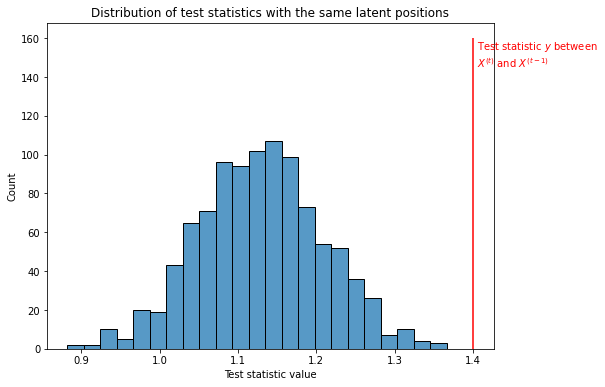

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))

plot = sns.histplot(y_vs, ax=ax)
plot.set_title("Distribution of test statistics with the same latent positions");
plot.set_xlabel("Test statistic value");

plot.vlines(y, 0, 160, colors='r')
plot.annotate("Test statistic $y$ between \n$X^{(t)}$ and $X^{(t-1)}$", (y+.005, 145), c='r');

The test statistic value that we have is not too weird and would be pretty reasonable to see under the assumption that the time-points share latent positions. However, we can't always eyeball stuff, and we need a way to formalize what it means for a test statistic to be "not too weird". We've already spoken about this formalization: our test statistic is  $y = ||X^{(t)} - X^{(t-1)}||$, and so we want to find some $c$ such that $P(||X^{(t)} - X^{(t-1)}|| > c)$ is small. This means that we want to have a low probability of seeing a $y$ greater than $c$.

## Using our test statistic to find p-values

In [39]:
y

1.4006430188199663

In [40]:
y_vs = np.array(y_vs)

(y_vs > y).sum() / N

0.0

## Hypothesis Testing to Figure out the Test Statistic

We'll look at testing for differences for the whole network at particular time points first, and then we'll explore what it looks like to test for differences in particular nodes.

We define individual vertex anomaly detection for the i-th vertex at time point $t^*$ as a test of the null hypothesis $H_{0i}^{(t*)}$ that t* is an anomaly time for vertex $i$.

1. embed with MASE or OMNI
    - MASE is better when graphs are close to equation (1), OMNI is better when they're far from eq (2) where  
      eq1: exactly COSIE: $X^{(t)} = VS^{(t)}$  
      eq2: allows changes in $V$ at some time points $X^{(t)} = VS^{(t)}$, $t \in [M] - \{t_1, ..., t_p\}$, else $V^{(t)} S^P{(t)}$, $t=t_j, j = 1, ..., p$
      so MASE is better when the networks don't fundamentally change across time points -- for example, when nodes never change community -- and OMNI is better when you allow for the network to be evolving at a more fundamental level.

2. for each time point, get test statistic: for any $\hat{X} \in \mathcal{R}^{n \times d}$, generate iid samples of $A \sim RDPG(\hat{X})$, then get test statistics $y^{(t)}$ or $y_i^{(t)}$ from it
    - using $y^{(t)} = ||\hat{X}^{(t)} - \hat{X}^{(t-1)}||$ for whole network
    - using $y_i^{(t)} = ||\hat{X_i}^{(t)} - \hat{X_i}^{(t-1)}||$ for vertex anomaly detection

3. Get distribution of test statistic with parametric bootstrap, using $\hat{X} = \hat{X}^{(t)}$ as the null distribution. Generate B samples of $y_b^{(t)}$ 

4. Calculate p-values as $p^{(t)} = \frac{\sum_{b=1, ..., B} I(y_b^{(t)} > y^{(t)})}{B}$

5. report p-values

In [9]:
from graspologic.embed import OmnibusEmbed as OMNI

omni = OMNI(n_components=2)
latents = omni.fit_transform(networks)

## Detecting anomaly times for particular nodes

## 

## References



- j1's paper -- heritability
- vivek's paper -- mcc

## Notes

guodong's stuff: uses MASE and OMNI combined with DCORR to do hypothesis testing
- vivek did something similar for MCC